<a href="https://colab.research.google.com/github/casangi/ngcasa/blob/master/docs/prototypes/cube_imaging_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cube Imaging 

For this demonstration we will use the data from the ALMA First Look at Imaging CASAguide (https://casaguides.nrao.edu/index.php/First_Look_at_Imaging).


## Installation

- S3Fs is a pythonic file interface to AWS S3 cloud storage (all the needed data is stored here).
- ngcasa is the prototype for the next generation of CASA software.
- graphviz is required for visualizing the task graph.



In [0]:
import os
os.system("pip install s3fs")
os.system("pip install ngcasa==0.0.7")
os.system("pip install cngi-prototype==0.0.50")
os.system("pip install graphviz")
print("complete")

complete


Load Data from AWS S3 Cloud


In [0]:
import s3fs
import xarray as xr
from cngi.dio import write_zarr 

# Initialize the S3 "file system"
s3 = s3fs.S3FileSystem(anon=True, requester_pays=False)

# Specify AWS S3 paths
bucket = "cngi-prototype-test-data/"
s3_path = bucket+"test_data/"

if s3.isdir(s3_path): # it's working
    print("AWS S3 Path found")

ddi = "0"
s3_vis = s3_path+"sis14_twhya_chan_avg_field_5_lsrk_pol_xx.vis.zarr/"+ddi
s3_metadata = s3_path+"sis14_twhya_chan_avg_field_5_lsrk_pol_xx.vis.zarr/global"
s3_casa_image = s3_path+"casa_twhya_standard_gridder_lsrk_cube_natural.img.zarr" #Image created by CASA

# Convert object stores to our desired MutableMapping interface
store_vis = s3fs.S3Map(root=s3_vis, s3=s3, check=False)
store_global = s3fs.S3Map(root=s3_metadata, s3=s3, check=False)
store_casa_image = s3fs.S3Map(root=s3_casa_image, s3=s3, check=False)

# Read zarr files
vis_dataset = xr.open_zarr(store=store_vis)
casa_image_dataset = xr.open_zarr(store=store_casa_image)

#Saving a local copy of the dataset and CASA image
vis_local_store = "sis14_twhya_field_5_lsrk_pol_xx.vis.zarr/"+ddi
write_zarr(vis_dataset,vis_local_store)
#xr.Dataset.to_zarr(vis_dataset,store=vis_local_store, mode='w')
vis_dataset = xr.open_zarr(store=vis_local_store)

image_local_store = "casa_twhya_standard_gridder_lsrk_cube_natural.img.zarr"
write_zarr(casa_image_dataset,image_local_store)
#xr.Dataset.to_zarr(casa_image_dataset,store=image_local_store, mode='w')
casa_image_dataset = xr.open_zarr(store=image_local_store)

print(vis_dataset)
print('##############################')
print(casa_image_dataset)
print('complete')

AWS S3 Path found
Time to store and execute graph  save_zarr 1.4240200519561768
Time to store and execute graph  save_zarr 1.7518079280853271
<xarray.Dataset>
Dimensions:        (baseline: 210, chan: 7, pair: 2, pol: 1, receptor: 2, spw: 1, time: 270, uvw_index: 3)
Coordinates:
    antennas       (baseline, pair) int32 dask.array<chunksize=(210, 2), meta=np.ndarray>
  * baseline       (baseline) int64 0 1 2 3 4 5 6 ... 204 205 206 207 208 209
  * chan           (chan) float64 3.725e+11 3.725e+11 ... 3.725e+11 3.725e+11
    chan_width     (chan) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    corr_product   (receptor, pol) int32 dask.array<chunksize=(2, 1), meta=np.ndarray>
    effective_bw   (chan) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    field          (time) <U6 dask.array<chunksize=(270,), meta=np.ndarray>
    interval       (time) float64 dask.array<chunksize=(270,), meta=np.ndarray>
    observation    (time) <U22 dask.array<chunksize=(270,), meta=np.ndarray>

## Initialize the Processing Environment
InitializeFramework instantiates a client object (does not need to be returned and saved by caller). Once this object exists, all Dask objects automatically know to use it for parallel execution.  

Omitting this step will cause the subsequent Dask dataframe operations to use the default built-in scheduler for parallel execution (which can actually be faster on local machines anyway)

Google Colab doesn't really support the dask.distributed environment particularly well.  The code is shown here commented out for reference only.

In [0]:
# normally you would want to run something like this on a local machine
#from cngi.direct import InitializeFramework
#client = InitializeFramework(workers=2, memory='6GB')
#print(client)

## Flag Data and Create Imaging Weights 
Using imaging_weights_parms['chan_mode'] = 'cube' is equavalent to perchanweightdensity=True in CASA.

In [0]:
from cngi.vis import applyflags
from ngcasa.synthesis.imaging import make_imaging_weights

vis_dataset_flagged = applyflags(vis_dataset, flags=['FLAG', 'FLAG_ROW'])

imaging_weights_parms = {}
imaging_weights_parms['weighting'] = 'natural'
imaging_weights_parms['chan_mode'] = 'cube'
imaging_weights_parms['imsize'] =  [200,400]
imaging_weights_parms['cell'] = [0.08, 0.08]

storage_parms = {}
storage_parms['to_disk'] = False 
vis_dataset_flagged = make_imaging_weights(vis_dataset_flagged, imaging_weights_parms, storage_parms)



######################### Start make_imaging_weights #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default imaging_weight_name  to  IMAGING_WEIGHT
Setting default robust  to  0.5
WEIGHT data variable found, will use WEIGHT to calculate  IMAGING_WEIGHT
##################### Created graph for make_imaging_weights #####################


## Create Dirty Cube Image

In [0]:
from ngcasa.synthesis.imaging import make_dirty_image

grid_parms = {}
grid_parms['chan_mode'] = 'cube'
grid_parms['imsize'] =  [200,400]
grid_parms['cell'] = [0.08, 0.08]
        
storage_parms = {}
storage_parms['to_disk'] =  True
storage_parms['outfile'] = 'twhya_standard_gridder_lsrk_cube_natural.img.zarr'
image_dataset = make_dirty_image(vis_dataset_flagged,grid_parms,storage_parms)

######################### Start make_dirty_image #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default imaging_weight_name  to  IMAGING_WEIGHT
Setting default image_name  to  DIRTY_IMAGE
Setting default sum_weight_name  to  SUM_WEIGHT
Setting default oversampling  to  100
Setting default support  to  7
Setting default fft_padding  to  1.2
Setting default append  to  False
Setting default compressor  to  Blosc(cname='zstd', clevel=2, shuffle=NOSHUFFLE, blocksize=0)
Saving dataset to  twhya_standard_gridder_lsrk_cube_natural.img.zarr
Time to store and execute graph  make_dirty_image 0.10632801055908203
##################### Created new dataset with make_dirty_image #####################


## Plot and Compare With CASA

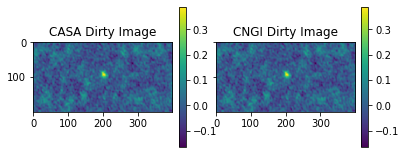

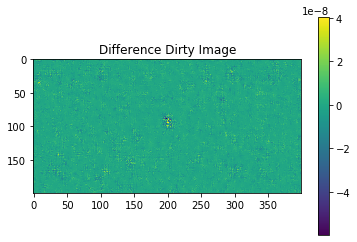

In [0]:
import matplotlib.pylab as plt
import numpy as np

chan = 3 #0 to 6

dirty_image = image_dataset.DIRTY_IMAGE[:,:,chan,0]
casa_dirty_image = casa_image_dataset['RESIDUAL'].values[:, :, chan, 0]
    
fig0, ax0 = plt.subplots(1, 2, sharey=True)
im0 = ax0[0].imshow(casa_dirty_image)
im1 = ax0[1].imshow(dirty_image)
ax0[0].title.set_text('CASA Dirty Image')
ax0[1].title.set_text('CNGI Dirty Image')
fig0.colorbar(im0, ax=ax0[0], fraction=0.046, pad=0.04)
fig0.colorbar(im1, ax=ax0[1], fraction=0.046, pad=0.04)
plt.show()
        
plt.figure()
plt.imshow(casa_dirty_image - dirty_image)
plt.title('Difference Dirty Image')
plt.colorbar()
plt.show()
    
dirty_image = dirty_image / np.max(np.abs(dirty_image))
casa_dirty_image = casa_dirty_image / np.max(np.abs(casa_dirty_image))

# Calculate max error
max_error_dirty_image = np.max(np.abs(dirty_image - casa_dirty_image)).values

# Calculate root mean square error
rms_error_dirty_image = np.linalg.norm(dirty_image - casa_dirty_image, 'fro')
    

## Execute this Notebook in Colab


https://colab.research.google.com/github/casangi/ngcasa/blob/master/docs/cube_imaging_example.ipynb